In [1]:
import sys  
sys.path.insert(0, '../search-engine')
from utils import *
import pandas as pd
from scipy.stats import spearmanr


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# NB2: Output Diversification

## Import data
Import data from search engine and clustering from NB1: Output Analysis

In [2]:
# Import data and work with a sample of size 10000
data = get_tweets(None, None, mode = "read", data_directory = '../data/')
data = data[:10000]

# Create tweetsDict, inverted index and tf, df, idf for each term of the sample data
tweetsDict = create_tweets_dict(data)
index, tf, df, idf = create_index_tfidf(data, len(data))

In [3]:
# Import clustering resulting from NB1 (QR1)
cluster_df = pd.read_csv("../other-outputs/clustering_output_10000.csv", index_col = "Unnamed: 0")
cluster_df.head()

,Text,Cluster
1335568906937896960,RT @9NEWSNANCY: 🤬@SpeakerPelosi has a LOT of d...,2
1335568907059466241,The Canadian strikes again https://t.co/Wj2i8L...,2
1335568907059535874,Call your legislators! #FightForTrump https://...,0
1335568907139231744,RT @BernardKerik: These are the four cowardice...,2
1335568907311132674,RT @realDonaldTrump: The answer to the Democra...,0


<font color = "DarkGreen">
    
## All following steps are related to a specific **query** and the **top-k**.  Specify them in the following cell:
</font>

In [4]:
query = "Vote"
topk = 20

## 1. Compute scores

Compute scores for specified query (tf-idf, personalized and w2v)

In [5]:
scores = personalized_rank(query, index, tf, idf, tweetsDict, data)
scores.head()

,tf-idf,partial,personalized,w2v
1335568907516559360,0.538773,0.001226,0.539707,103.341381
1335568908254769153,0.659922,0.000182,0.660061,55.017729
1335568909072625664,0.933081,0.000677,0.933597,56.501144
1335568909517385728,0.864048,0.002166,0.865698,49.477293
1335568909949399040,0.538773,0.000358,0.539046,57.722008


In [6]:
# Append clusters to scores results
scores.index = scores.index.astype('int64')
scores = scores.join(cluster_df, how= "left")
scores.head()

,tf-idf,partial,personalized,w2v,Text,Cluster
1335568907516559360,0.538773,0.001226,0.539707,103.341381,I vote #AshishSharma for Modi 2\nThe journey ...,1
1335568908254769153,0.659922,0.000182,0.660061,55.017729,RT @jaehyunbom__: JAEHYUN SAID TO VOTE!!\n\n#M...,2
1335568909072625664,0.933081,0.000677,0.933597,56.501144,yall we didnt vote for fave male group ...,2
1335568909517385728,0.864048,0.002166,0.865698,49.477293,RT @ArtValley818_: List of the 25 RINOs who sa...,2
1335568909949399040,0.538773,0.000358,0.539046,57.722008,@BTSNewsBrasil I vote for #BTS for Worldwide F...,2


## 3. Diversity score
Diversity score aggregates a partial score to the tf-idf score, therefore, it has to be computed with respect to a certain query

\begin{equation*} \mathbf{diversity\_score = tfidf + \lambda * partial\_score} \end{equation*}
Where: 

- $\lambda = 1/3 * max(tfidf)$ regulating the impact on the score 

- $ partial\_score = 1 - \frac{cluster\_size}{total\_size}$

In [7]:
# Compute diversity score
div_score = []
lamb = 1/3
clusters_size = scores.Cluster.value_counts()
max_tfidf = scores["tf-idf"].max(axis=0)
for i, value in scores.iterrows():
    partial = 1 - clusters_size[value["Cluster"]]/len(scores)
    score = value["tf-idf"] + lamb * max_tfidf * partial
    div_score.append(score)
    
# Add it to scores dataFrame
scores["diversity"] = div_score

## 4. Visualize the impact of the diversity score 

See tf-idf and diversity score for the test query:

In [8]:
scores[["tf-idf", "diversity", "Cluster"]].head()

,tf-idf,diversity,Cluster
1335568907516559360,0.538773,1.064015,1
1335568908254769153,0.659922,0.995110,2
1335568909072625664,0.933081,1.268268,2
1335568909517385728,0.864048,1.199236,2
1335568909949399040,0.538773,0.873961,2


Display top-5 results sorting by both scores

In [9]:
display_ranking(scores, tweetsDict, query, score = "tf-idf", top_k = topk)


Top-20 documents sorted by tf-idf score
1335563686526787584: Did we vote for this?

1335576417753559040: @LLinWood VOTE VOTE VOTE TRUMP SAID VOTE!! SO YOU BETTER VOTE. DO NOT LISTEN TO THIS DEMOCRAT

1335559290854268936: @BLACK4PINKS_ @mandujenduk @OH_mes2 Ok these are the results Kblinks tweet it Worldwide Fans'Choice TOP 10 BTS vote 7,009,302 Blackpink vote 3,441,450 NCT vote 1,558,362 Seventeen vote 1,557,358 Twice vote 1,411,877 Treasure vote 1,147,150, EXO vote 939,661 Ateez vote 915,812 TXT vote 911,042 GOT7 vote 863,344

1335571429090340865: @BTSChartDailyx @BTS_twt Better to vote here too! Only 17 hours left to vote! 🚨 #2 (↓) TMA Popularity – -7,519 gap VOTE NOW PLEASE !!!🙏🙏 Vote here: https://t.co/bEC9gCLr8S https://t.co/kacxXb7aL1 https://t.co/YBpVYW5yvu

1335565369407369217: @btsvotingorg @BTS_twt Better to vote here too! Only 17 hours left to vote! 🚨 #2 (↓) TMA Popularity – -7,519 gap VOTE NOW PLEASE !!! Vote here: https://t.co/bEC9gCLr8S https://t.co/kacxXb7aL1 https://t.

In [10]:
display_ranking(scores, tweetsDict, query, score = "diversity", top_k = topk)


Top-20 documents sorted by diversity score
1335563686526787584: Did we vote for this?

1335576417753559040: @LLinWood VOTE VOTE VOTE TRUMP SAID VOTE!! SO YOU BETTER VOTE. DO NOT LISTEN TO THIS DEMOCRAT

1335559290854268936: @BLACK4PINKS_ @mandujenduk @OH_mes2 Ok these are the results Kblinks tweet it Worldwide Fans'Choice TOP 10 BTS vote 7,009,302 Blackpink vote 3,441,450 NCT vote 1,558,362 Seventeen vote 1,557,358 Twice vote 1,411,877 Treasure vote 1,147,150, EXO vote 939,661 Ateez vote 915,812 TXT vote 911,042 GOT7 vote 863,344

1335565369407369217: @btsvotingorg @BTS_twt Better to vote here too! Only 17 hours left to vote! 🚨 #2 (↓) TMA Popularity – -7,519 gap VOTE NOW PLEASE !!! Vote here: https://t.co/bEC9gCLr8S https://t.co/kacxXb7aL1 https://t.co/tO2ViRwCr4

1335571429090340865: @BTSChartDailyx @BTS_twt Better to vote here too! Only 17 hours left to vote! 🚨 #2 (↓) TMA Popularity – -7,519 gap VOTE NOW PLEASE !!!🙏🙏 Vote here: https://t.co/bEC9gCLr8S https://t.co/kacxXb7aL1 https:/

In [11]:
def store_query_and_results(scores, query, topk):
    # Store queries
    try: df = pd.read_csv("../other-outputs/RQ2_queries.tsv", sep="\t")
    except: df = pd.DataFrame(columns = ["id", "query"])
        
    if query not in df["query"].values:
        query_id = len(df) + 1
        df = df.append({"id":query_id, "query":query}, ignore_index=True)
        df.to_csv("../other-outputs/RQ2_queries.tsv", sep="\t", index=False)

    else: query_id = int(df[df["query"] == query]["id"].values)
    
    # Store results
    scores_df1 = scores[["tf-idf", "Text", "Cluster"]].sort_values(by="tf-idf", ascending=False)[:topk]
    scores_df1.to_csv("../other-outputs/RQ2_Q{}_noDiversity.tsv".format(query_id), sep="\t", index_label = "Tweet id")

    scores_df2 = scores[["diversity", "Text", "Cluster"]].sort_values(by="diversity", ascending=False)[:topk]
    scores_df2.to_csv("../other-outputs/RQ2_Q{}_diversity.tsv".format(query_id), sep="\t", index_label = "Tweet id")

In [12]:
store_query_and_results(scores, query, topk)

## 5. Coverage and ranking difference

Compute **correlation coefficient** between original (tf-idf score) and diversity score

In [13]:
coef, p = spearmanr(scores["tf-idf"], scores["diversity"])
print("Correlation coefficient betweet tf-idf and diversity scores: {}". format(round(coef, 3)))

Correlation coefficient betweet tf-idf and diversity scores: 0.575


Compute **coverage** for both scores

In [14]:
def plot_coverage(df, score, topk):
    clusters = df.sort_values(by = score, ascending = False)[:topk]["Cluster"]
    fig = plt.figure(figsize=(20,7))
    count = dict(sorted(clusters.value_counts().items()))
    to_plot = {}
    
    for c in range(3):
        try: to_plot[c] = count[c]
        except: to_plot[c] = 0
            
    plt.barh(list(to_plot.keys()), to_plot.values(), color = "lightblue")
    
    plt.xlabel("Count in top-{}".format(topk), fontsize=15)
    plt.ylabel("Clusters", fontsize=15)
    plt.title("Clusters coverage using {} score".format(score), fontsize = 20)
    

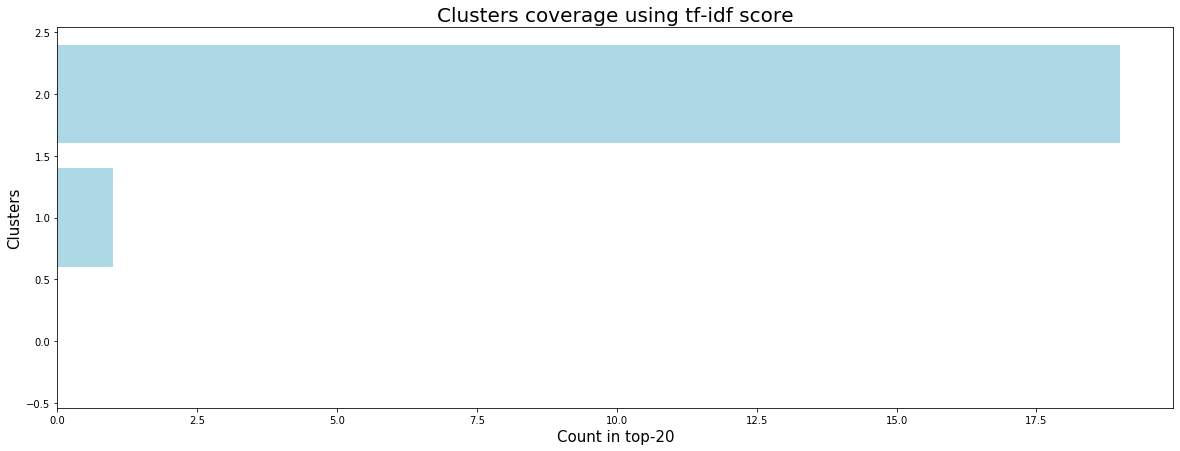

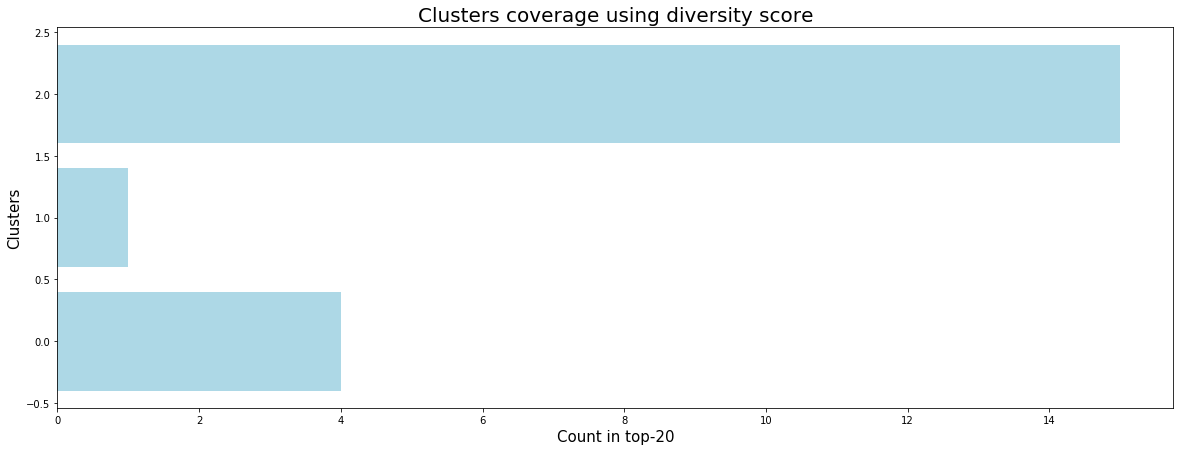

In [15]:
plot_coverage(scores, "tf-idf", topk)
plot_coverage(scores, "diversity", topk)